In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint, solve_ivp

Few observations and changes:

In the book you dont see which FFT amplitudes are related to which freqs. Autohrs ,dont explain why they generate frequencies and why they shift them.

In practice, amplitudes are related to frequencies which start from 0 Hz, increase by df = 1/dt to n/2/dt, in the middle of array, and then go from -n/2/dt to 0 in second half.

in numpy you can generate list of frequencies using np.fft.fftfreq(n=n, d=dt).

we are generally not interested in negative freqs, since they are unphysical and redundant and take first, positive half.

Other way is to shift frequencies to from -n/2/dt, ..., n/2/dt using np.fft.fftshift(freq)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Lets derive Fourier transform integrals from fourier function aproximation:

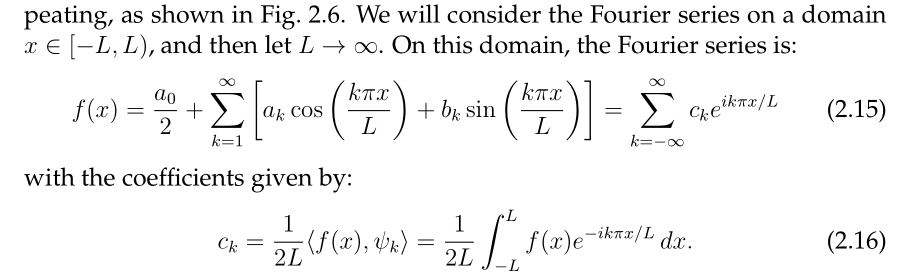

change k space to w space. i see it as a change of variables, where 1D line of k-points are mapped to 1D line of w_k points and intervals (L) are expressed in terms of Dw_k. this solves an ambiguety of what to use to express L, w_k or Dw_k. w_k i an independant variable, so it makes no sense.

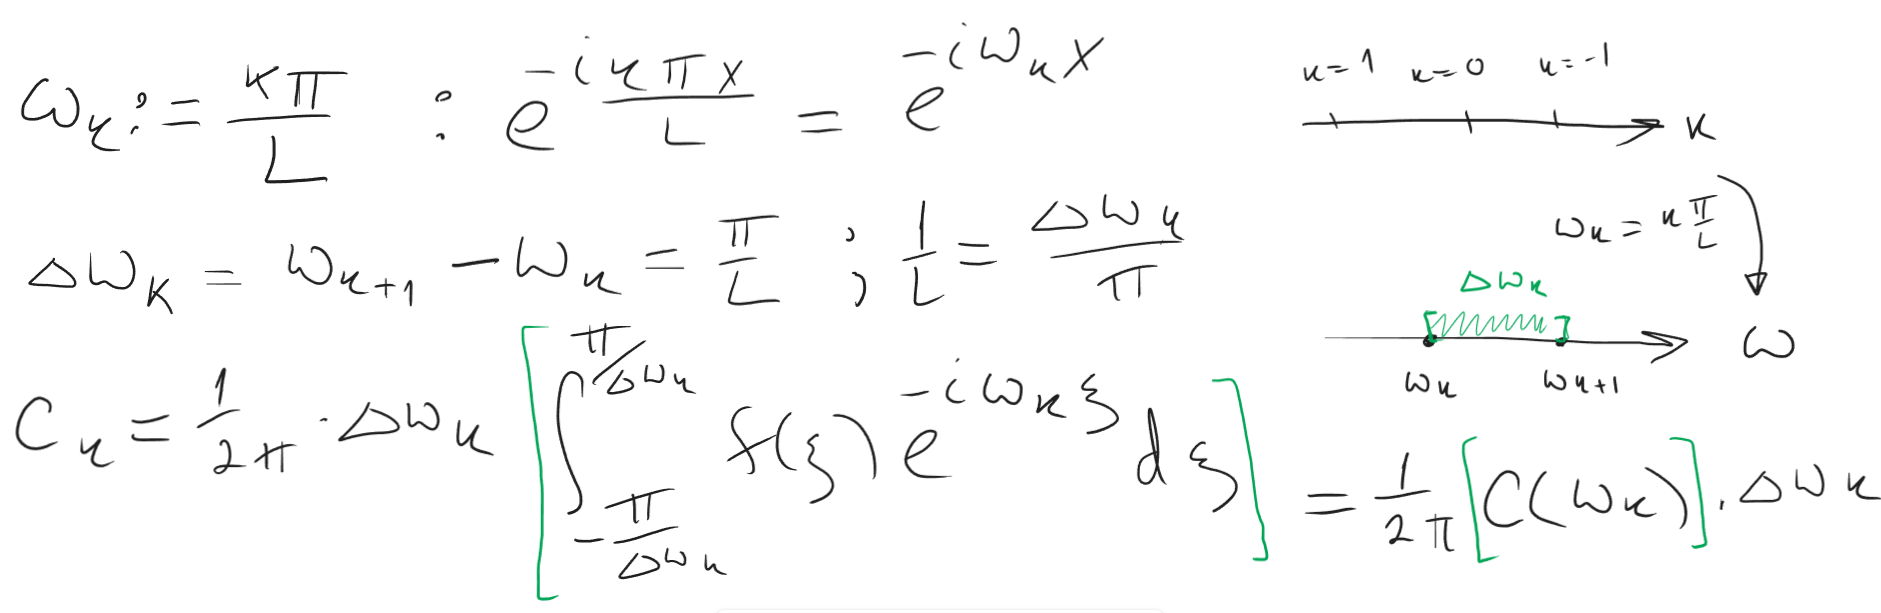

prepare to expand L to infinity by taking a limit. Dw_k will shrink. limit of a sum  f(x_i)*D(x_i) , when i goes to inf is a definition of an itegral

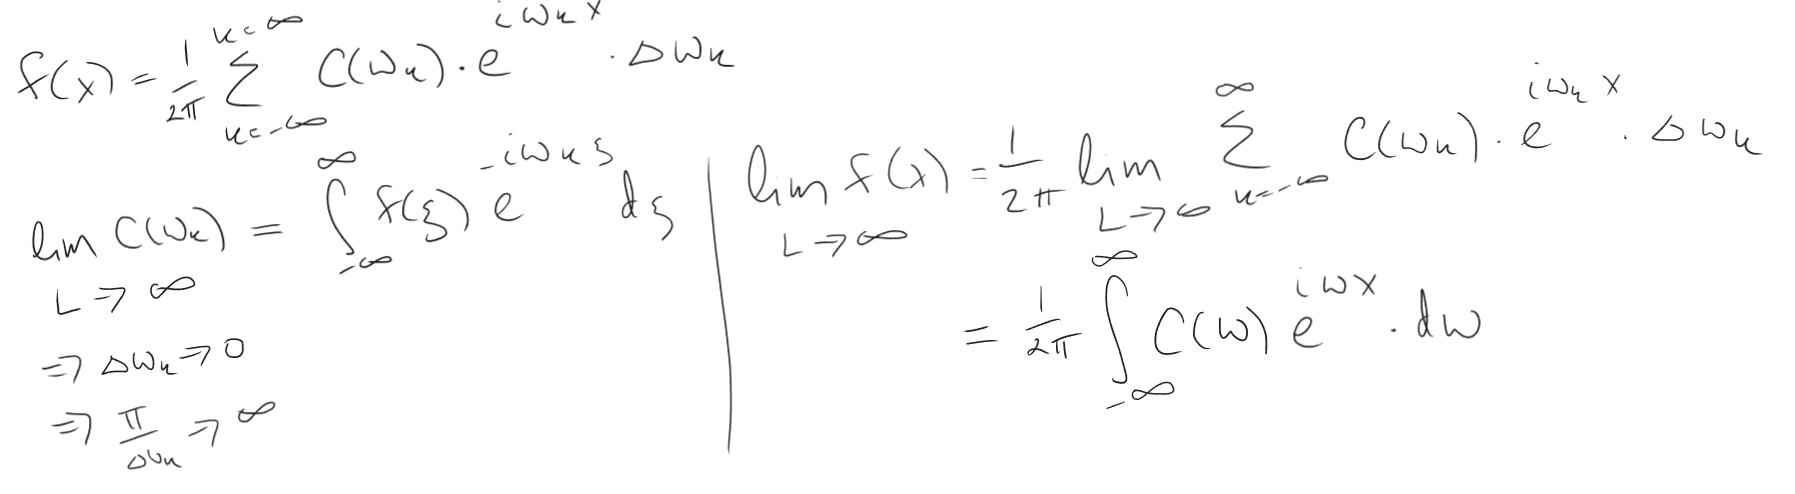

change C(w) abriviation and define it as fourier transform of f(x). our original f(x) is an inverser fourier transform. constants 1/2pi may be distributed into different parts, may be split into two 1/sqrt(2pi) and distributed to both transforms 

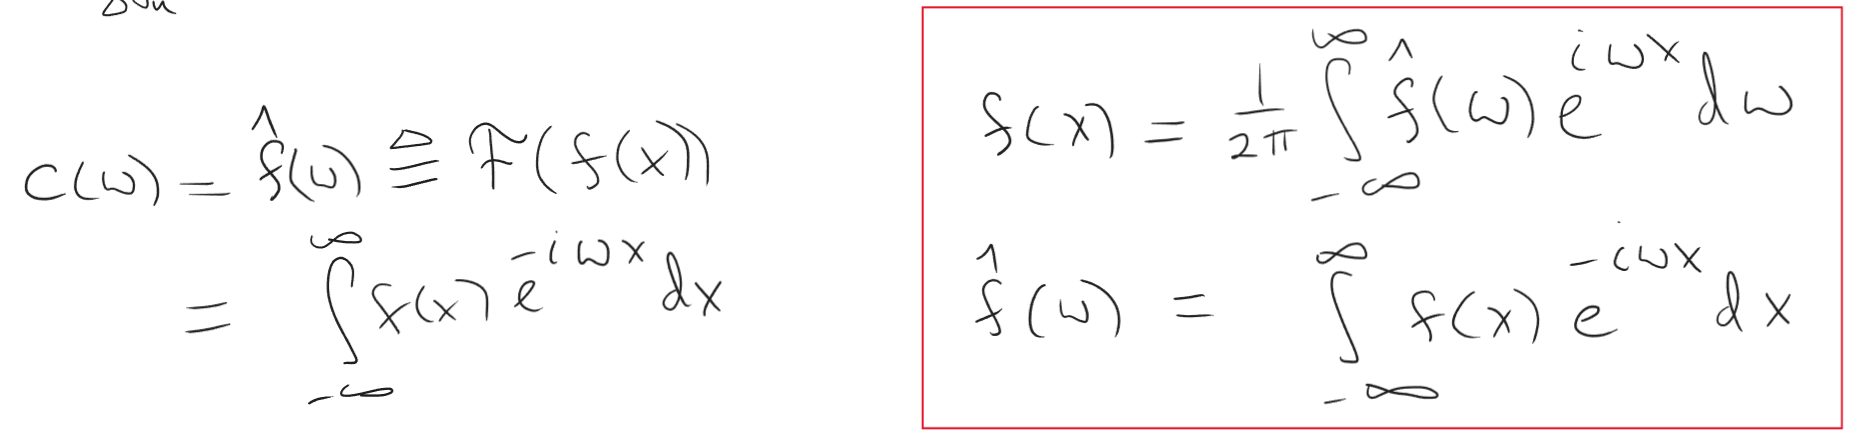

FFT Fast Fourier Transform

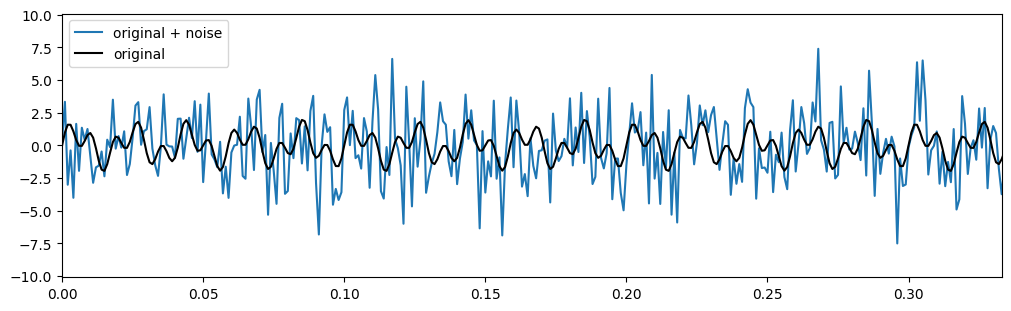

In [2]:
#generate a signal
dt      = 0.001
t       = np.arange(0, 1, dt, float)
n       = t.size
freq_1  = 50
freq_2  = 120
f_OG    = np.sin(2 * np.pi * freq_1 * t) + np.sin(2 * np.pi * freq_2 * t)
f       = f_OG + 2.5*np.random.randn(*f_OG.shape)
fig, ax = plt.subplots(1,1, layout='constrained',  figsize=(10, 3))
ax.plot(t, f, label = 'original + noise')
ax.plot(t, f_OG, label = 'original', c = 'k')
ax.legend()
ax.set_xlim(t[0],t[n//3])
miny = np.max(f_OG)
miny2 = np.max(f)
ax.set_ylim(-miny2 -0.5 , miny2 + 0.5)
miny = np.max(f_OG)

In [3]:
# generate FFT
f_hat   = np.fft.fft(f, n)
freq = np.fft.fftfreq(n=n, d=dt)

# power spectrum - intensity squared - per total entries
PSD     = f_hat * np.conj(f_hat) /n # *operator here is element-wise multiplication
L       = np.arange(1, n//2)

# binary mask for high power frequencies
where_large        = PSD > 100   
which_freq = np.argwhere(where_large).flatten()
print('frequency spikes at: ',freq[which_freq], 'Hz')

# turn low power entries to zero       
PSD_filtered        = PSD * where_large    
# same with frequency spectrum     
f_hat_filtered      = f_hat * where_large
# reconstruct back main signal
fft_filtered_inv    = np.fft.ifft(f_hat_filtered)

frequency spikes at:  [  50.  120. -120.  -50.] Hz


c:\Users\Hot Mexican\VS_Code_Proj\.venv\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Hot Mexican\VS_Code_Proj\.venv\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


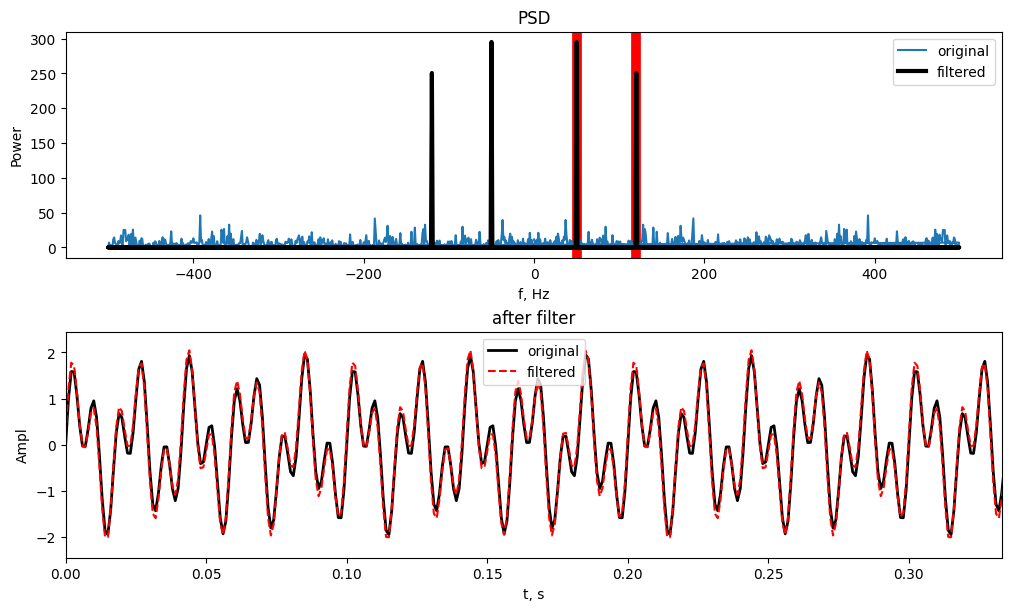

In [4]:
plt.rcParams['figure.figsize'] = [10,6]
fig, ax = plt.subplots(2,1, layout='constrained')
ax = ax.reshape(ax.size)

ax[0].axvline(x=freq_1, c = 'r', linestyle = '-', lw = 7)
ax[0].axvline(x=freq_2, c = 'r', linestyle = '-', lw = 7)
ax[0].plot(freq, PSD            , label = 'original')
ax[0].plot(freq, PSD_filtered   , label = 'filtered', lw = 3, c = 'k')

ax[0].set_title('PSD')
ax[0].set_xlabel('f, Hz')
ax[0].set_ylabel('Power')
ax[0].legend()

ax[1].plot(t, f_OG                , label = 'original', c = 'k', lw = 2)
ax[1].plot(t, fft_filtered_inv   , label = 'filtered', linestyle= '--', c = 'r')
ax[1].set_xlim(t[0],t[n//3])
ax[1].set_ylim(-miny -0.5 , miny + 0.5)
ax[1].set_title('after filter')
ax[1].set_xlabel('t, s')
ax[1].set_ylabel('Ampl')
ax[1].legend()

Derivative:

Taking a fourier transform of a derivative reduces to multiplying with $i\omega$. 

In practice it means that in PDE, we can drop derivative of one variable and turn it into ODE.

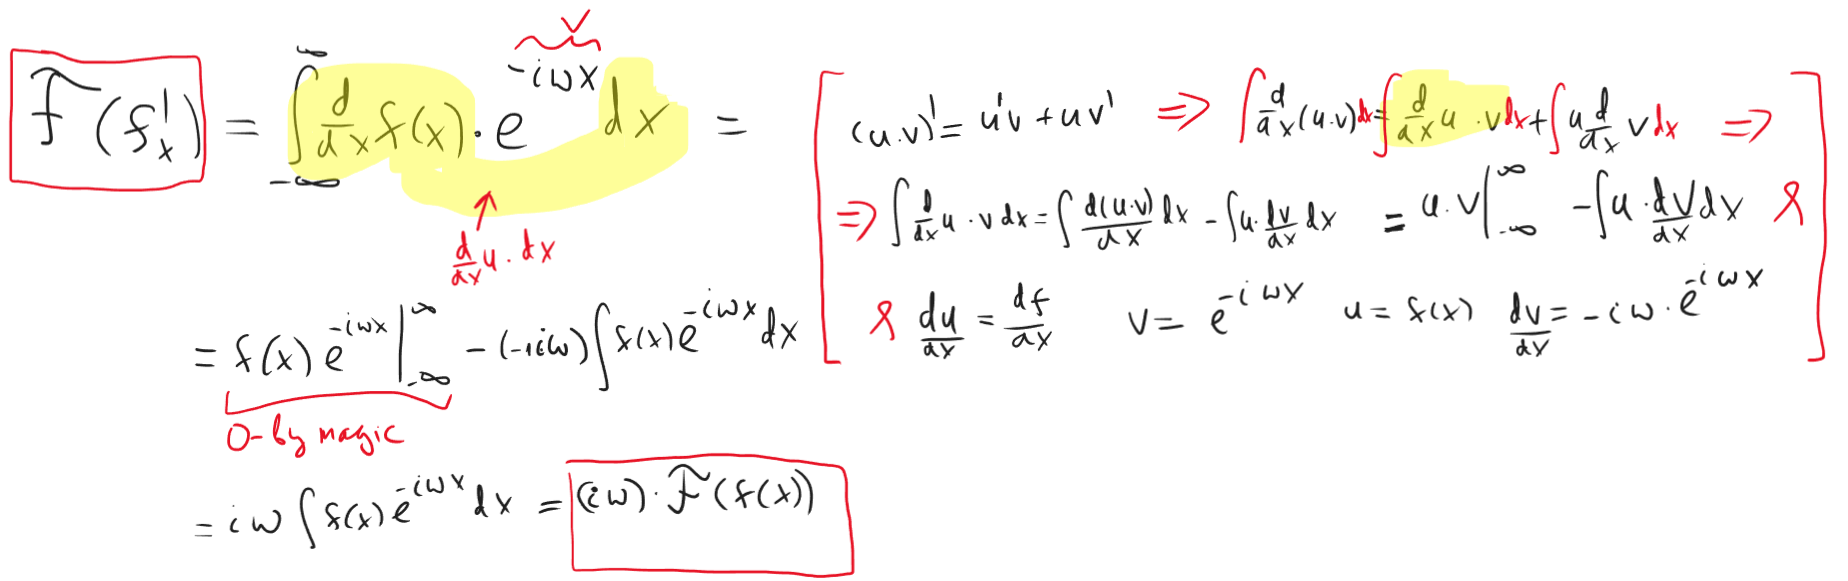


Using same method, but in reverse, we can compute derivatives of f(x) = f'(x) $=>$ by inverting $i\omega F[f(x)]$

dx= 0.234375


C:\Users\Hot Mexican\AppData\Local\Temp\ipykernel_14432\3347012042.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i] = df/dx


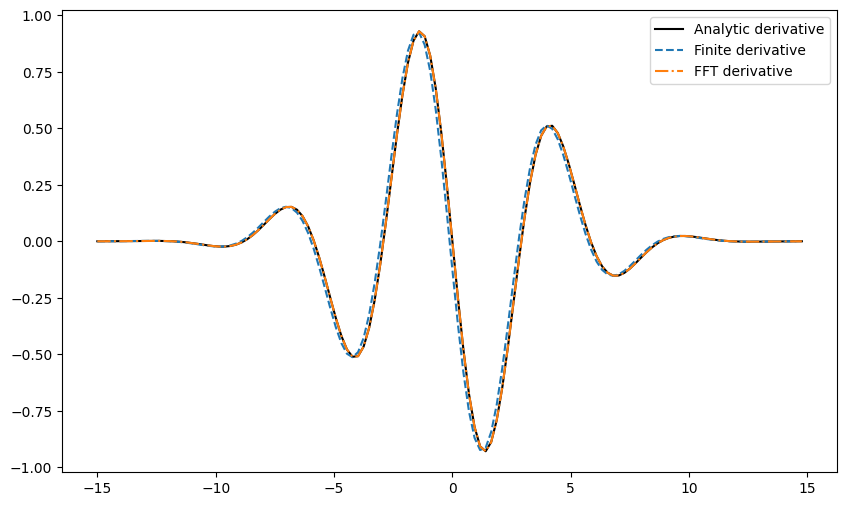

In [5]:
#constuct f(x)
n = 128
L = 30
dx = L / n;print('dx=', dx)
x = np.arange(-L/2, L/2, dx,dtype='complex_')
f = np.cos(x)* np.exp(-x**2 / 25)

# calculate analytic derivative:
df = -np.sin(x)*np.exp(-x**2 / 25) + np.cos(x)*np.exp(-x**2 / 25)*(-2*x/25)

# calculate derivative using finite differences:
def finite_diff(x,f):
    d = np.zeros(x.size - 1)
    for i,_ in enumerate(d):
        dx = x[i+1] - x[i]
        df = f[i+1] - f[i]
        d[i] = df/dx
    return d
# calculate derivative using fourer transform:
f_hat   = np.fft.fft(f)                     #F[f(x)]
kappa = 2*np.pi*np.fft.fftfreq(n=n, d=dx)   # kappa =  2pi/lambda = 2pi*dx

df_hat = (1j) * kappa * f_hat               #i*w*F[f(x)] (%)
df_FFT = np.real(np.fft.ifft(df_hat))       # derivative  = F^(-1)[%]

plt.plot(x, df, label='Analytic derivative', c = 'k')
plt.plot(x[:-1],finite_diff(x,f), label='Finite derivative', linestyle = '--')
plt.plot(x, df_FFT, label='FFT derivative', linestyle = '-.')
plt.legend()

Inverse fourier of product of two fourier transforms reduces to convolution of two original functions

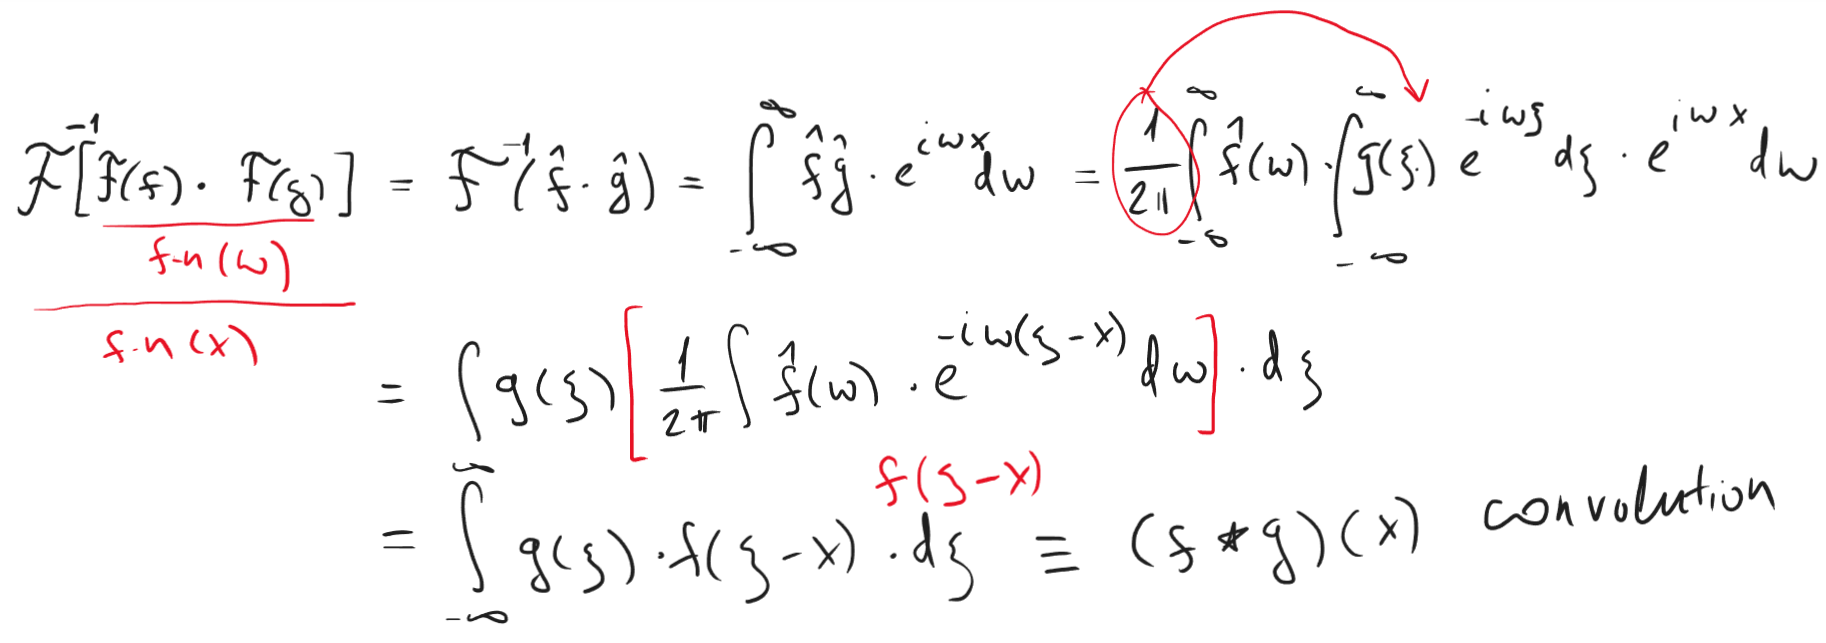

it is useful

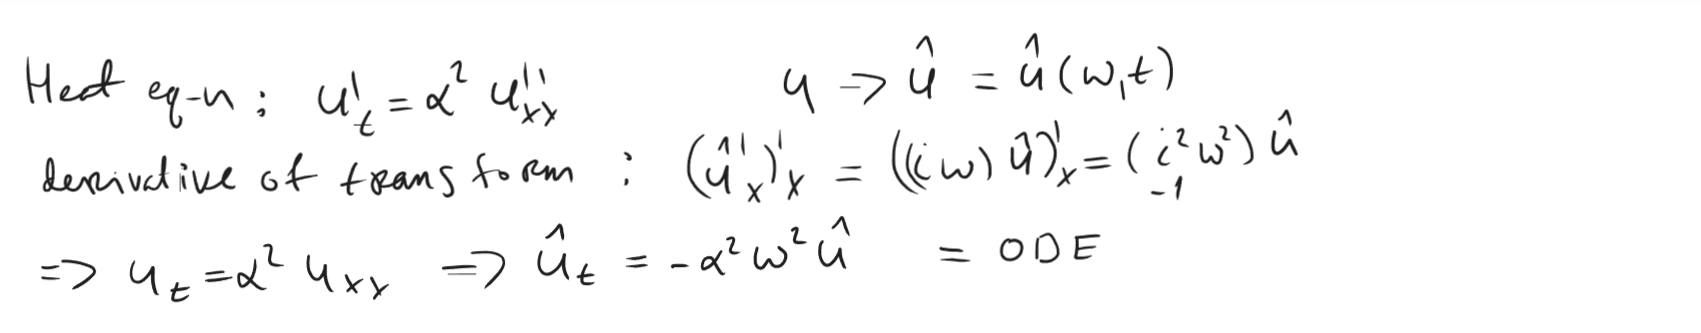

i am not sure if $\omega$ is a function of u, and whether to take full or partial derivative of t. full is easily solvable.

u is, kind of, a function-solution of this ODE, so it should have unique $\omega$ set

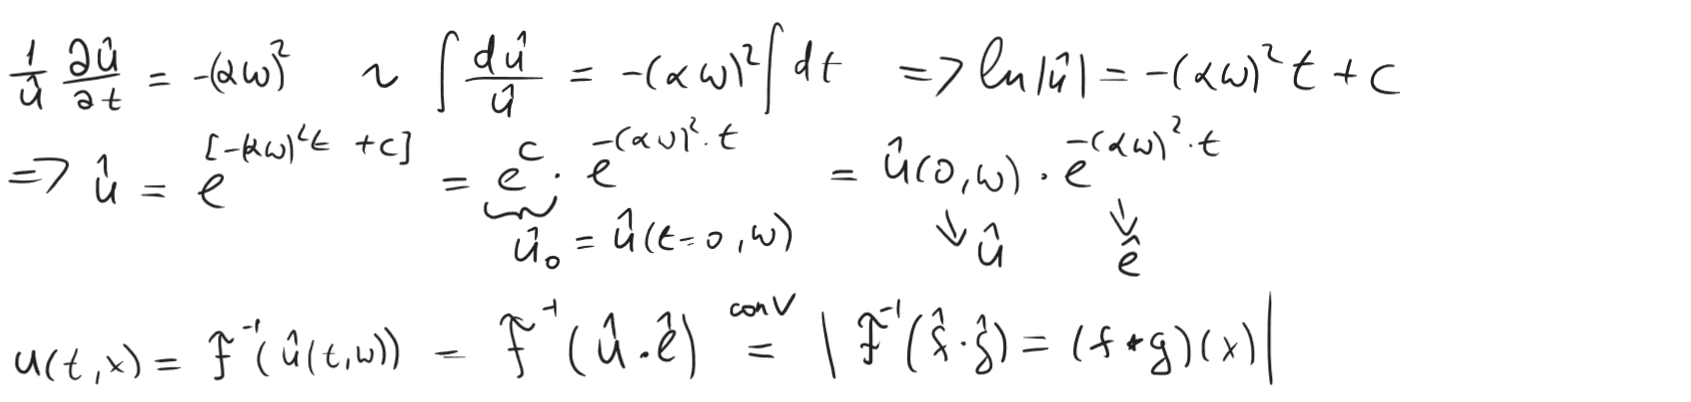

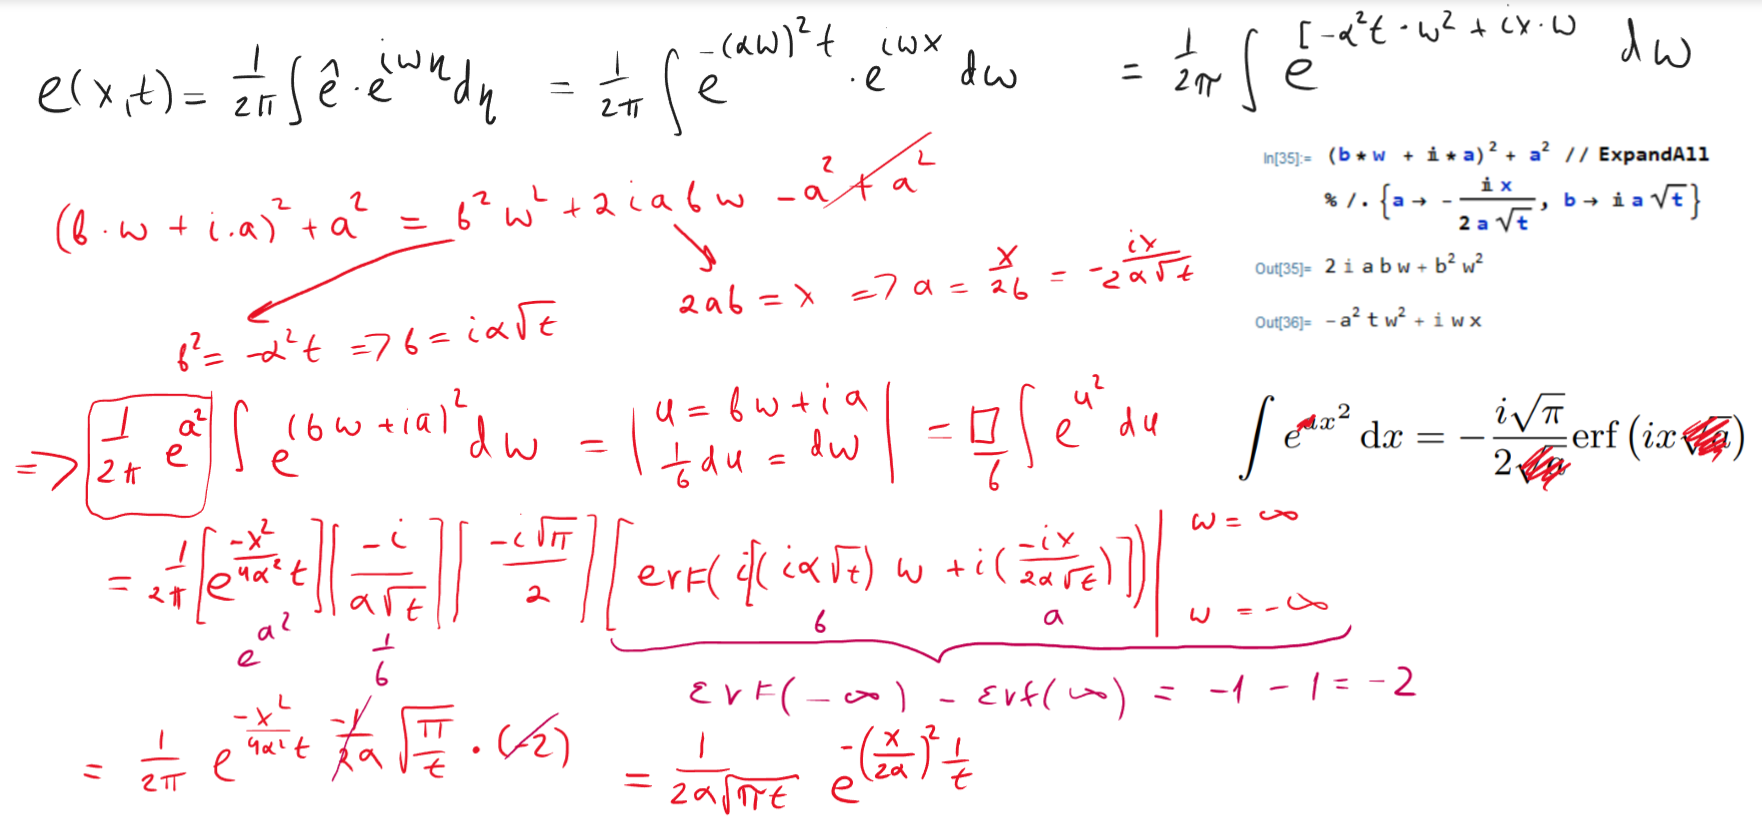

Define a problem: u0 -> box function.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
a = 2
L = 100
N = 1000
dx = L/N
x = np.arange(-L/2, L/2, dx)

u0 = x*0
fr = int(N*0.4)
to = int(N*0.6)
idx = np.arange(fr,to,1)
u0[idx] = 1

Solve using convolution

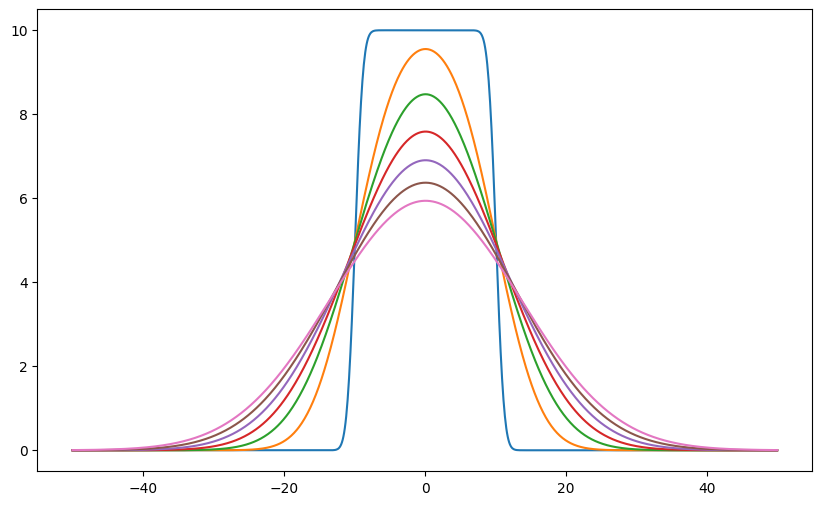

In [7]:
# use convolution
for ti in np.arange(0.1, 21, 3):
    e = 1/(2 * a * np.sqrt(np.pi * ti))* np.exp(-(x/2/a)**2/ti)
    plt.plot(x,np.convolve(e, u0, mode='same'))

Solve PDE by transforming into ODE.

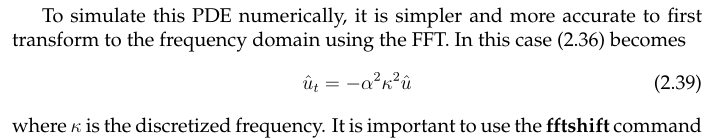

In [8]:
# 
kappa = 2*np.pi*np.fft.fftfreq(n=N, d=dx)
C =  -a**2 * kappa * kappa
fn = lambda t,y: C* y 
t = np.arange(0,10,0.1)
print(t.size)

sol = solve_ivp(fn, [0, max(t)], np.fft.fft(u0), t_eval=t)

sol_ifft = np.fft.ifft(sol.y, axis = 0).real

100


Plot evolution #1. Offset 2d plots:

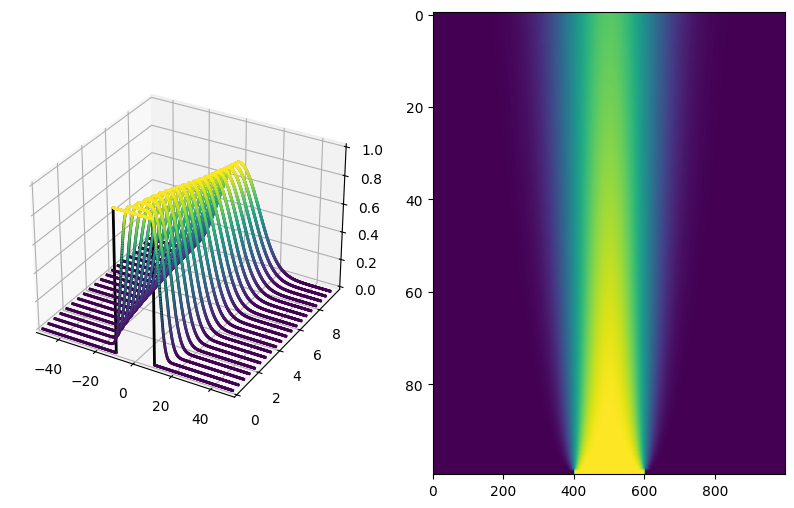

In [9]:
import matplotlib.pyplot as plt
import numpy as np
step = 5
times_idx = range(t.size)[::step]
times = t[::step]
# Create a 3D plot
fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
axis1 = fig.add_subplot(121, projection='3d')
for tid, ti in zip(times_idx,times):
    yi = sol_ifft[:,tid]
    #print(np.max(yi))
    axis1.scatter(x, yi, zs=ti, zdir='y', c = yi, s = 1)
    axis1.plot(x, yi, zs=ti, zdir='y', lw = 2, c='k')
axis1.set(xlim=(x[0],x[-1]), ylim=(0,t[-1]), zlim=(0,1))
axis2 = fig.add_subplot(122)
sol_ifft_img = np.rot90(sol_ifft,1)
axis2.imshow(sol_ifft_img,aspect='auto', cmap='viridis')


Plot evolution #2. Offset polygons:

[(-50.0, 50.0),
 (0.0, 10.0),
 (0.0, 1.0),
 Text(0.5, 0, 'X'),
 Text(0.5, 0.5, 'Time'),
 Text(0.5, 0, 'Temp')]

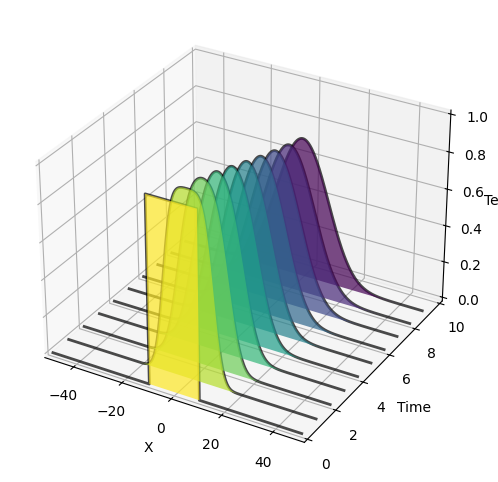

In [10]:
from matplotlib.collections import PolyCollection
def polygon_under_graph(x, y):
    """
    Construct the vertex list which defines the polygon filling the space under
    the (x, y) line graph. This assumes x is in ascending order.
    """
    return [(x[0], 0.), *zip(x, y), (x[-1], 0.)]

ax = plt.figure().add_subplot(projection='3d')
times_idx = range(t.size)[::10]
times = t[::10]
verts = [polygon_under_graph(x, np.fft.ifft(sol.y[:,i]))
         for i in times_idx]
facecolors = plt.colormaps['viridis_r'](np.linspace(0, 1, len(verts)))

poly = PolyCollection(verts, facecolors=facecolors, alpha=.7)
ax.add_collection3d(poly, zs=times, zdir='y')
for tid, ti in zip(times_idx,times):
    yi = np.real(np.fft.ifft(sol.y[:,tid]))
    ax.plot(x, yi, zs=ti, zdir='y', lw = 2, c='k', alpha = 0.7)

ax.set(xlim=(-50,50), ylim=(0,10), zlim=(0,1),
       xlabel='X', ylabel='Time', zlabel='Temp')


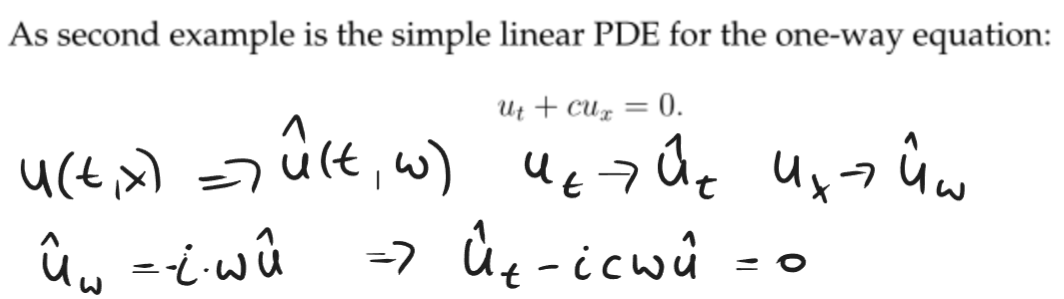

correction. should multipy by $i\omega$ not $-i\omega$

In [11]:
c = 2
L = 20
N = 1000
dx = L/N

x = np.arange(-L/2,L/2, dx)

kappa = np.fft.fftfreq(n = N, d = dx)

u0 = 1/np.cosh(x)

dt = 0.1
t_max = 100*dt
t = np.arange(0, t_max, dt)

fn = lambda t,y: -(1j) * c* kappa * y

sol = solve_ivp(fn, [0, t_max], np.fft.fft(u0), t_eval=t)

sol_ifft = np.fft.ifft(sol.y, axis = 0).real



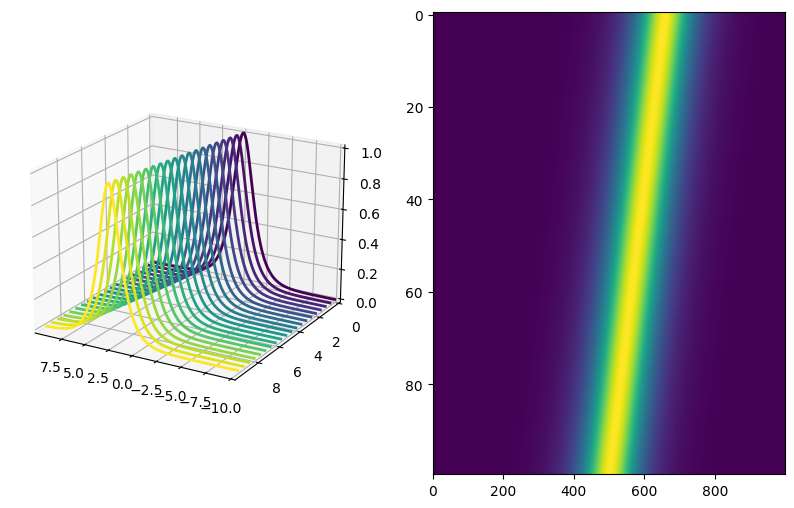

In [12]:
step = 5
times_idx = range(t.size)[::step]
times = t[::step]
# Create a 3D plot
fig = plt.figure()
axis1 = fig.add_subplot(121, projection='3d')
colors = plt.colormaps['viridis_r'](np.linspace(1, 0, len(times)))
for tid, ti, clr in zip(times_idx,times, colors):
    yi = sol_ifft[:,tid]
    axis1.plot(x, yi, zs=ti, zdir='y', lw = 2, c = clr)

axis1.set(xlim=(x[0],x[-1]), ylim=(0,t[-1]), zlim=(0,np.max(u0)))
axis1.view_init(elev=20, azim=120, roll=0)

axis2 = fig.add_subplot(122)
sol_ifft_img = np.rot90(sol_ifft,1)
axis2.imshow(sol_ifft_img,aspect='auto', cmap='viridis')

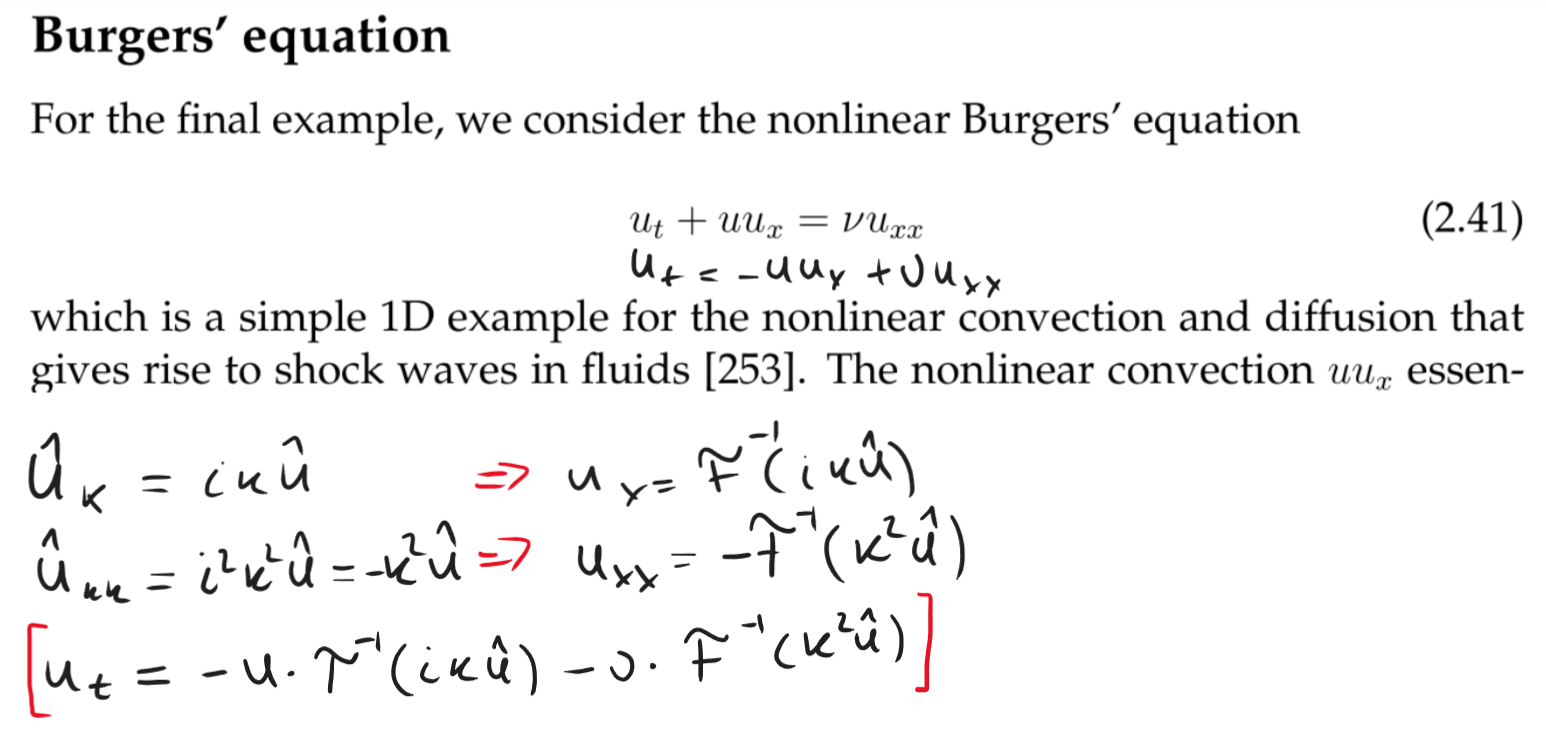

In [13]:
nu = 0.001

L = 20
N = 1000
dx = L/N
x = np.arange(-L/2, L/2, dx)

kappa = 2*np.pi*np.fft.fftfreq(n = N, d = dx)

u0 = 1/np.cosh(x)

dt = 0.025
t_max = 100*dt
t = np.arange(0, t_max, dt)

def fn(u,t):    # changed order u and t for odeint()
    u_hat   = np.fft.fft(u)
    ux      =  np.fft.ifft(1j * kappa * u_hat)
    uxx     =  np.fft.ifft( - np.power(kappa,2)* u_hat)
    dudx = -u*ux + nu * uxx
    return dudx.real

u = odeint(fn,u0,t)

sol_ifft = sol.y

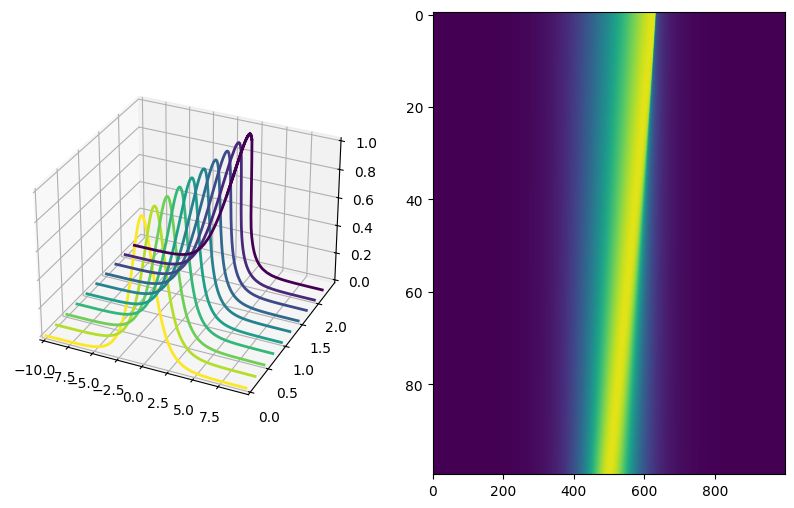

In [14]:
step = 10
times_idx = range(t.size)[::step]
times = t[::step]
# Create a 3D plot
fig = plt.figure()
axis1 = fig.add_subplot(121, projection='3d')
colors = plt.colormaps['viridis_r'](np.linspace(0, 1, len(times)))
for tid, ti, clr in zip(times_idx,times, colors):
    yi = u[tid,:]
    axis1.plot(x, yi, zs=ti, zdir='y', lw = 2, c = clr)

axis1.set(xlim=(x[0],x[-1]), ylim=(0,t[-1]), zlim=(0,np.max(u0)))
axis1.view_init(elev=30, azim=-65, roll=0)

axis2 = fig.add_subplot(122)
sol_ifft_img = np.flipud(u)
axis2.imshow(sol_ifft_img, aspect='auto', cmap='viridis')